In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [41]:
from PIL import Image
import random
import shutil

In [3]:
DATADIR = 'D:\cap-stone\DAD_DATASET\\'

# TestDATADIR = 'D:\cap-stone\TESTING\\'
categories = ['adjusting_radio', 'drinking', 'messaging_left', 'messaging_right',
              'normal_driving_1', 'normal_driving_2',
              'reaching_behind', 'talking_with_passenger', 'talking_with_phone_left',
              'talking_with_phone_right']
front = True
IMG_SIZE = 128

In [4]:
for category in categories:
    class_num = categories.index(category)
    if front == True:
        path_depth = os.path.join(DATADIR+f'{category}'+'\\front_depth')
        path_IR = os.path.join(DATADIR+f'{category}'+'\\front_IR')
        for i, (img1, img2) in enumerate(zip(os.listdir(path_depth), os.listdir(path_IR))):
            img_array1 = cv2.imread(os.path.join(path_depth, img1))
            img_array2 = cv2.imread(os.path.join(path_IR, img2))
            img_array = cv2.add(img_array1, img_array2)
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            cv2.imwrite(
                f"D:\cap-stone\Early_FUSION_NEW\EarlyFusion\{category}\image_{i}.png", img_array)

In [6]:
dataset_path = "D:\\cap-stone\\Early_FUSION_NEW\\EarlyFusion\\"
train_dataset_path = "D:\\cap-stone\\Early_FUSION_NEW\\Train\\"
test_dataset_path = "D:\\cap-stone\\Early_FUSION_NEW\\Test\\"
validation_dataset_path = "D:\\cap-stone\\Early_FUSION_NEW\\Val\\"
data_path = "D:\\cap-stone\\Early_FUSION_NEW\\NEW\\"


BATCH_SIZE = 32

In [7]:
train_percentage = 0.80  # 80% for training, 20% for validation

In [8]:
categories = os.listdir(dataset_path)

In [9]:
# Ensure the target directories exist.
os.makedirs(train_dataset_path, exist_ok=True)
os.makedirs(test_dataset_path, exist_ok=True)
os.makedirs(validation_dataset_path, exist_ok=True)

In [10]:
for category in categories:
    category_path = os.path.join(dataset_path, category)

    # List all the images in the category folder.
    images = os.listdir(category_path)

    # Calculate how many images will go into the training set.
    num_train_images = int(len(images) * train_percentage)

    # Randomly shuffle the list of images.
    random.shuffle(images)

    # Split the images into training and validation sets.
    train_images = images[:num_train_images]
    test_images = images[num_train_images:]

    # Move the images to their respective directories.
    for image in train_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(data_path, category, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(test_dataset_path, category, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset splitting completed.")

Dataset splitting completed.


In [11]:
for category in categories:
    category_path = os.path.join(data_path, category)

    # List all the images in the category folder.
    images = os.listdir(category_path)

    # Calculate how many images will go into the training set.
    num_train_images = int(len(images) * train_percentage)

    # Randomly shuffle the list of images.
    random.shuffle(images)

    # Split the images into training and validation sets.
    train_images = images[:num_train_images]
    val_images = images[num_train_images:]

    # Move the images to their respective directories.
    for image in train_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(train_dataset_path, category, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(validation_dataset_path, category, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset splitting completed.")

Dataset splitting completed.


In [12]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(
                                                        IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 6400 images belonging to 10 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path, target_size=(
    IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)

Found 1600 images belonging to 10 classes.


In [14]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : adjusting_radio
1 : drinking
2 : messaging_left
3 : messaging_right
4 : normal_driving_1
5 : normal_driving_2
6 : reaching_behind
7 : talking_with_passenger
8 : talking_with_phone_left
9 : talking_with_phone_right


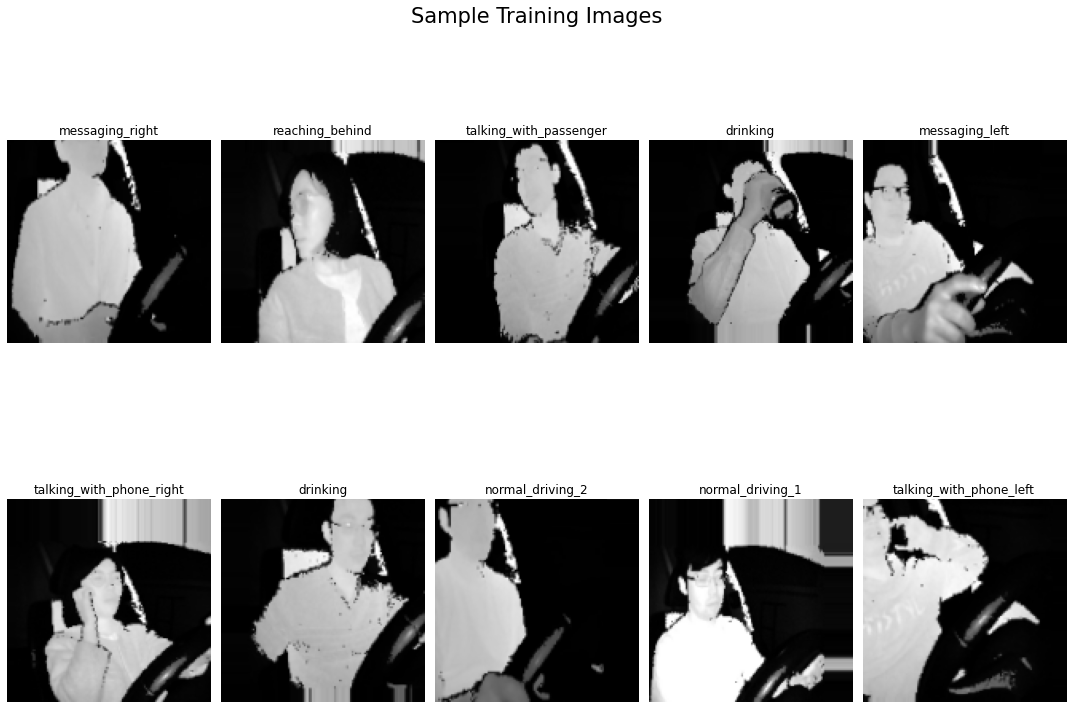

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [4]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding='valid',
               input_shape=(128, 128, 3)),

        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='valid',
               kernel_regularizer=l2(0.00005)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='valid',
               kernel_regularizer=l2(0.00005)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=10, activation='softmax')
    ])

    return model

In [5]:
cnn_model = create_model()

In [ ]:
import keras
import keras.layers

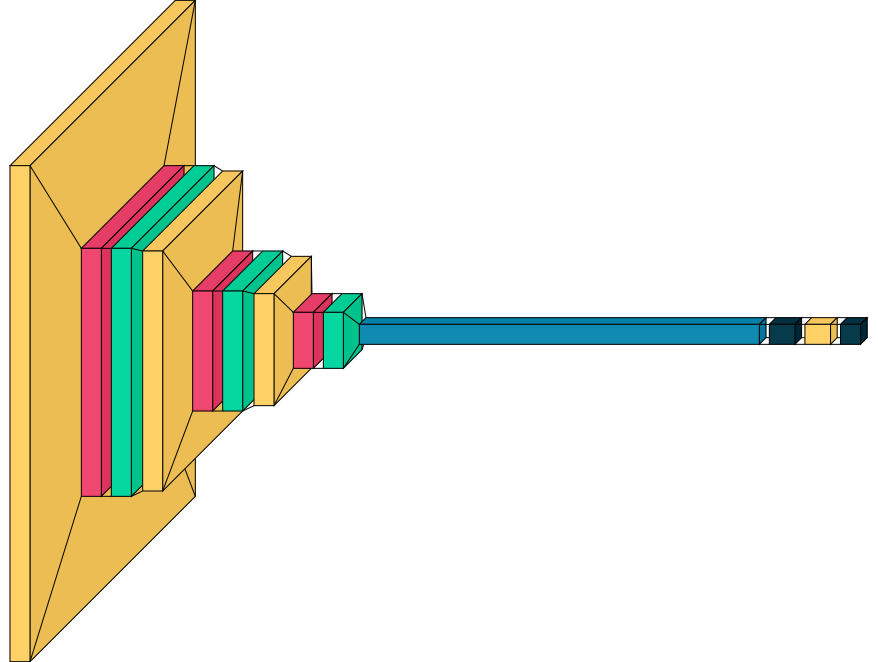

In [7]:
import visualkeras
visualkeras.layered_view(cnn_model)

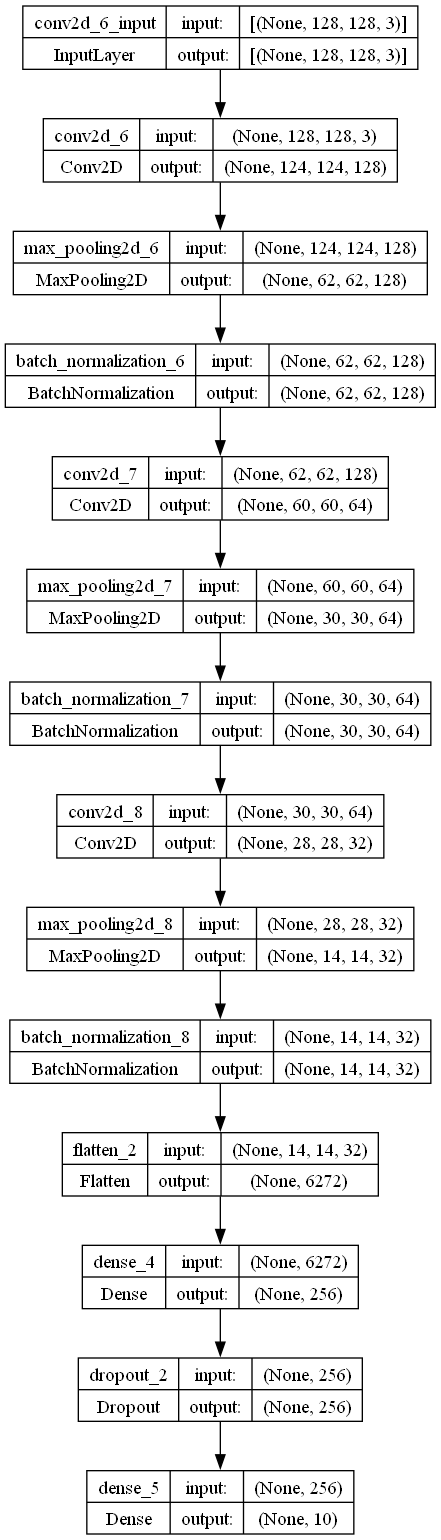

In [47]:
tf.keras.utils.plot_model(
    cnn_model, to_file='Early_Fusion.png', show_shapes=True)

In [18]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 128)     9728      
                                                                 
 activation (Activation)     (None, 124, 124, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0

In [19]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [20]:
optimizer = Adam(learning_rate=0.001)

In [21]:
cnn_model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [22]:
history = cnn_model.fit(train_generator, epochs=15, validation_data=validation_generator,
                        callbacks=[reduce_lr])

Epoch 1/15
200/200 [==============================] - 273s 1s/step - loss: 2.4800 - accuracy: 0.1231 - val_loss: 2.3918 - val_accuracy: 0.1625 - lr: 0.0010
Epoch 2/15
200/200 [==============================] - 241s 1s/step - loss: 2.2716 - accuracy: 0.1384 - val_loss: 2.2294 - val_accuracy: 0.1744 - lr: 0.0010
Epoch 3/15
200/200 [==============================] - 240s 1s/step - loss: 2.2187 - accuracy: 0.1661 - val_loss: 2.0086 - val_accuracy: 0.2294 - lr: 0.0010
Epoch 4/15
200/200 [==============================] - 254s 1s/step - loss: 2.0828 - accuracy: 0.2181 - val_loss: 1.8875 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 5/15
200/200 [==============================] - 262s 1s/step - loss: 1.9386 - accuracy: 0.2681 - val_loss: 3.1652 - val_accuracy: 0.1744 - lr: 0.0010
Epoch 6/15
200/200 [==============================] - 263s 1s/step - loss: 1.7427 - accuracy: 0.3386 - val_loss: 3.4590 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 7/15
200/200 [==============================] - 269s 1s/st

In [23]:
cnn_model.save('earlyFusion_1350.h5')

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

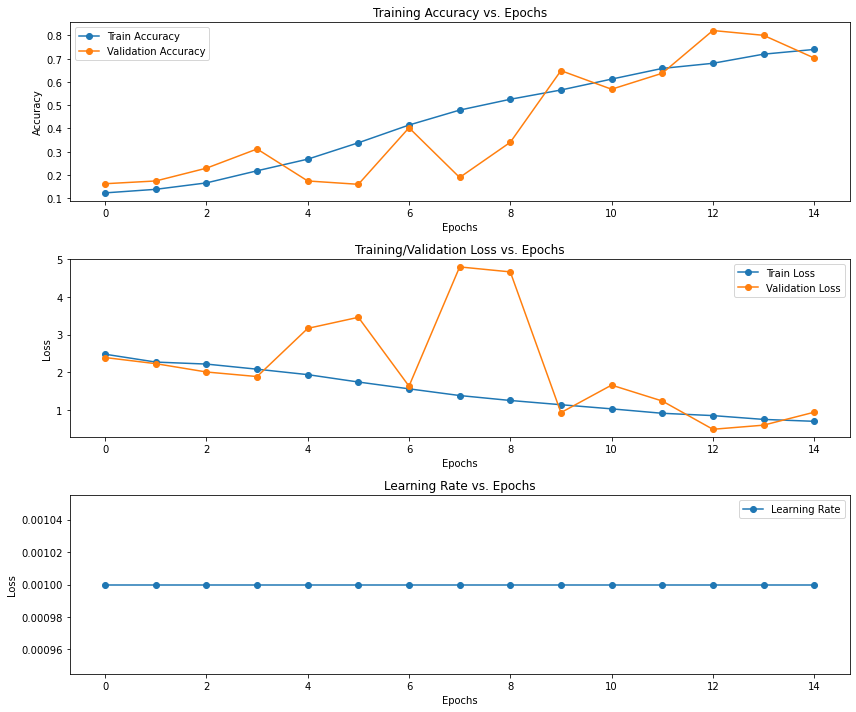

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [55]:
# os.makedirs(os.path.dirname("D:\cap-stone\Early\TESTING_DATA"), exist_ok=True)

In [ ]:
# test_percentage = 0.2
# TEST_BF_path = "D:\cap-stone\Early\TESTING_DATA"
# for category in categories:
#     category_path = os.path.join(dataset_path, category)
#     dirs = os.listdir(category_path)
#     for dir in dirs:
#         # List all the images in the category folder.
#         images = os.listdir(dir)

#         # Calculate how many images will go into the training set.
#         num_test_images = int(len(images) * test_percentage)

#         # Randomly shuffle the list of images.
#         random.shuffle(images)

#         # Split the images into training and validation sets.
#         test_images = images[:num_train_images]

#         # Move the images to their respective directories.
#         for image in test_images:
#             src = os.path.join(category_path, dir, image)
#             dst = os.path.join(TEST_BF_path, category, dir, image)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.copy(src, dst)
#         break

# print("Dataset splitting completed.")

In [56]:
# TDATADIR = "D:\cap-stone\DAD\Test\\"
# for category in categories:
#     class_num = categories.index(category)
#     if front == True:
#         path_depth = os.path.join(TDATADIR+f'{category}'+'\\front_depth')
#         path_IR = os.path.join(TDATADIR+f'{category}'+'\\front_IR')
#         for i, (img1, img2) in enumerate(zip(os.listdir(path_depth), os.listdir(path_IR))):
#             if i == 300:
#                 break
#             img_array1 = cv2.imread(os.path.join(path_depth, img1))
#             img_array2 = cv2.imread(os.path.join(path_IR, img2))
#             img_array = cv2.add(img_array1, img_array2)
#             img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#             cv2.imwrite(
#                 f"D:\cap-stone\Early\TESTING_NEW\{category}\image_{i}.png", img_array)

In [27]:
# test_dataset = "D:\cap-stone\Early\Test\\"

In [28]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=(
                                                      IMG_SIZE, IMG_SIZE),
                                                  class_mode='categorical')

Found 2000 images belonging to 10 classes.


In [29]:
predictions = cnn_model.predict(test_generator)

63/63 [==============================] - 21s 330ms/step


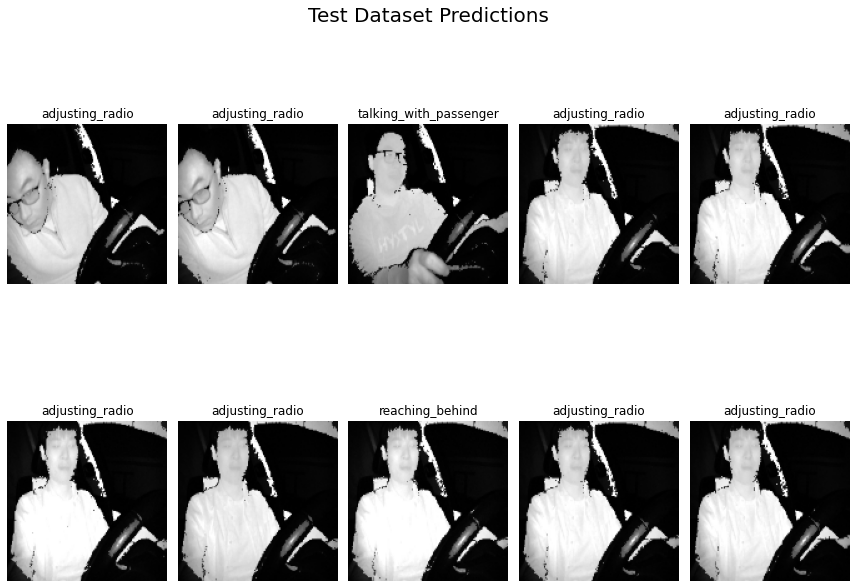

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [31]:
test_loss, test_accuracy = cnn_model.evaluate(
    test_generator, batch_size=BATCH_SIZE)

63/63 [==============================] - 13s 203ms/step - loss: 0.8786 - accuracy: 0.7075


In [32]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.8786178231239319
Test Accuracy: 0.7074999809265137


In [33]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

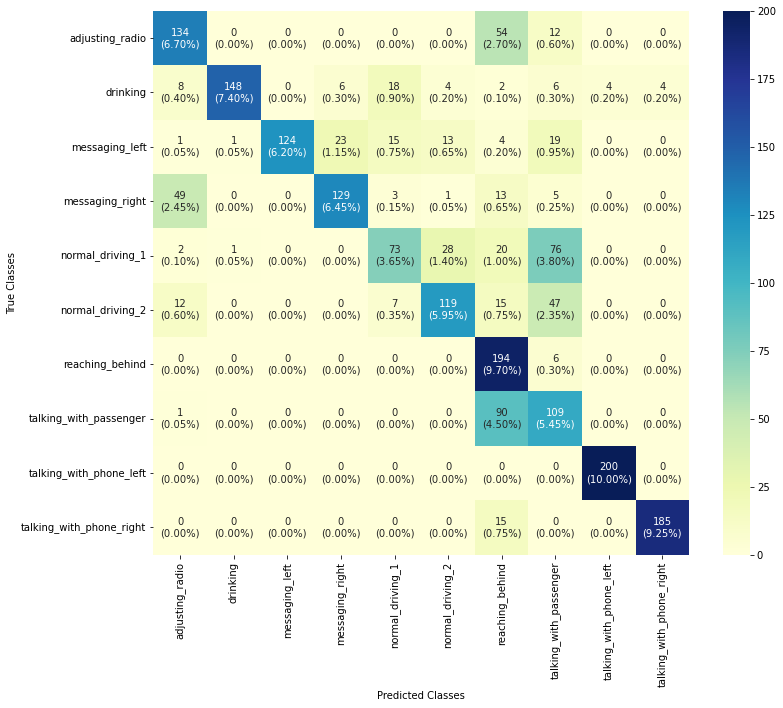

In [34]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value)
                     for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(
    group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(10, 10)

plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [35]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                          precision    recall  f1-score   support

         adjusting_radio       0.65      0.67      0.66       200
                drinking       0.99      0.74      0.85       200
          messaging_left       1.00      0.62      0.77       200
         messaging_right       0.82      0.65      0.72       200
        normal_driving_1       0.63      0.36      0.46       200
        normal_driving_2       0.72      0.59      0.65       200
         reaching_behind       0.48      0.97      0.64       200
  talking_with_passenger       0.39      0.55      0.45       200
 talking_with_phone_left       0.98      1.00      0.99       200
talking_with_phone_right       0.98      0.93      0.95       200

                accuracy                           0.71      2000
               macro avg       0.76      0.71      0.71      2000
            weighted avg       0.76      0.71      0.71      2000



In [36]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [37]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

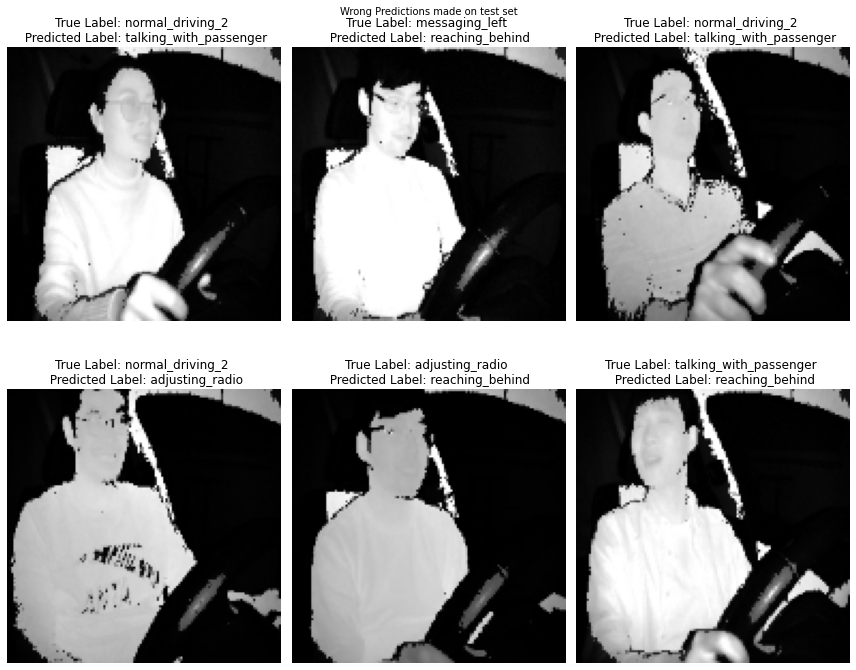

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(3):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(
            f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset_path, test_img[idx])
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=10)
plt.show()